In [54]:
# Import AWS and Sagemaker SDKs and get files access
import boto3
import io
from sagemaker import get_execution_role

role = get_execution_role()
bucket ='sagemaker-data-energy-demand'

In [55]:
!pip install lightgbm

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [56]:
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Light GBM 
import lightgbm as lgb

In [87]:
# Import data 

CITY = 'LosAngeles'
train_key = 'dataframes/%s/train/data_train.csv' % CITY
validation_key = 'dataframes/%s/test/data_validation.csv' % CITY

train_location = 's3://{}/{}'.format(bucket, train_key)
validation_location = 's3://{}/{}'.format(bucket, validation_key)

df_train = pd.read_csv(train_location, index_col='datetime')
df_validation = pd.read_csv(validation_location, index_col='datetime')

In [88]:
df_train = df_train.drop('hour(t-1)', axis=1)
df_validation = df_validation.drop('hour(t-1)', axis=1)

In [89]:
def data_sppliter(df, label):
    cols = list(df.columns)
    cols.remove(label)
    X = df[cols]
    y = df[label]
    return X, y

X_train, y_train = data_sppliter(df_train, label='demand(t)')
X_validation, y_validation = data_sppliter(df_validation, label='demand(t)')

In [90]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_validation = pd.DataFrame(X_validation_scaled, columns=X_validation.columns, index=X_validation.index)

## Create LightGBM Model

In [91]:
# Creating model
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=300)

In [92]:
gbm.fit(X_train, y_train,
        eval_set=[(X_validation, y_validation)],
        eval_metric='l1',
        early_stopping_rounds=20)

print('Starting predicting...')

# predict
df_validation['LightGBM_demand_prediction'] = gbm.predict(X_validation, num_iteration=gbm.best_iteration_)

# eval
#print('The rmse of prediction is:', mean_squared_error(y_true, y_validation) ** 0.5)

[1]	valid_0's l1: 444.893	valid_0's l2: 276376
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l1: 430.073	valid_0's l2: 256137
[3]	valid_0's l1: 416.368	valid_0's l2: 238068
[4]	valid_0's l1: 403.629	valid_0's l2: 221602
[5]	valid_0's l1: 391.162	valid_0's l2: 206419
[6]	valid_0's l1: 379.475	valid_0's l2: 192784
[7]	valid_0's l1: 368.625	valid_0's l2: 180411
[8]	valid_0's l1: 357.261	valid_0's l2: 168532
[9]	valid_0's l1: 346.76	valid_0's l2: 157921
[10]	valid_0's l1: 336.737	valid_0's l2: 148111
[11]	valid_0's l1: 327.269	valid_0's l2: 139131
[12]	valid_0's l1: 317.849	valid_0's l2: 130670
[13]	valid_0's l1: 309.273	valid_0's l2: 123031
[14]	valid_0's l1: 300.5	valid_0's l2: 115803
[15]	valid_0's l1: 292.66	valid_0's l2: 109593
[16]	valid_0's l1: 285.25	valid_0's l2: 103803
[17]	valid_0's l1: 277.252	valid_0's l2: 97842.8
[18]	valid_0's l1: 270.453	valid_0's l2: 92897.6
[19]	valid_0's l1: 263.945	valid_0's l2: 88418.8
[20]	valid_0's l1: 256.27	valid_0's l2

In [68]:
df_lgb = df_validation[['LightGBM_demand_prediction']].copy()

In [69]:
# save as csv file to continue in another notebook
lgb_buffer = io.StringIO()
s3_resource = boto3.resource('s3')
key = 'predict/%s/pred_lightgbm.csv' % CITY

df_lgb.to_csv(lgb_buffer, compression=None)
s3_resource.Object(bucket, key).put(Body=lgb_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '16370B9E4190B347',
  'HostId': 'kis7HXnpvE/YEkXaZTEfYgRuhD1BPnXjdobP9auREA51rH0A7KAgTF4TU3+kAafi60uawpNWrg8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'kis7HXnpvE/YEkXaZTEfYgRuhD1BPnXjdobP9auREA51rH0A7KAgTF4TU3+kAafi60uawpNWrg8=',
   'x-amz-request-id': '16370B9E4190B347',
   'date': 'Sun, 19 Jan 2020 01:47:35 GMT',
   'etag': '"7b4b9a4a08b52e65d0b2a0807250d8da"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"7b4b9a4a08b52e65d0b2a0807250d8da"'}

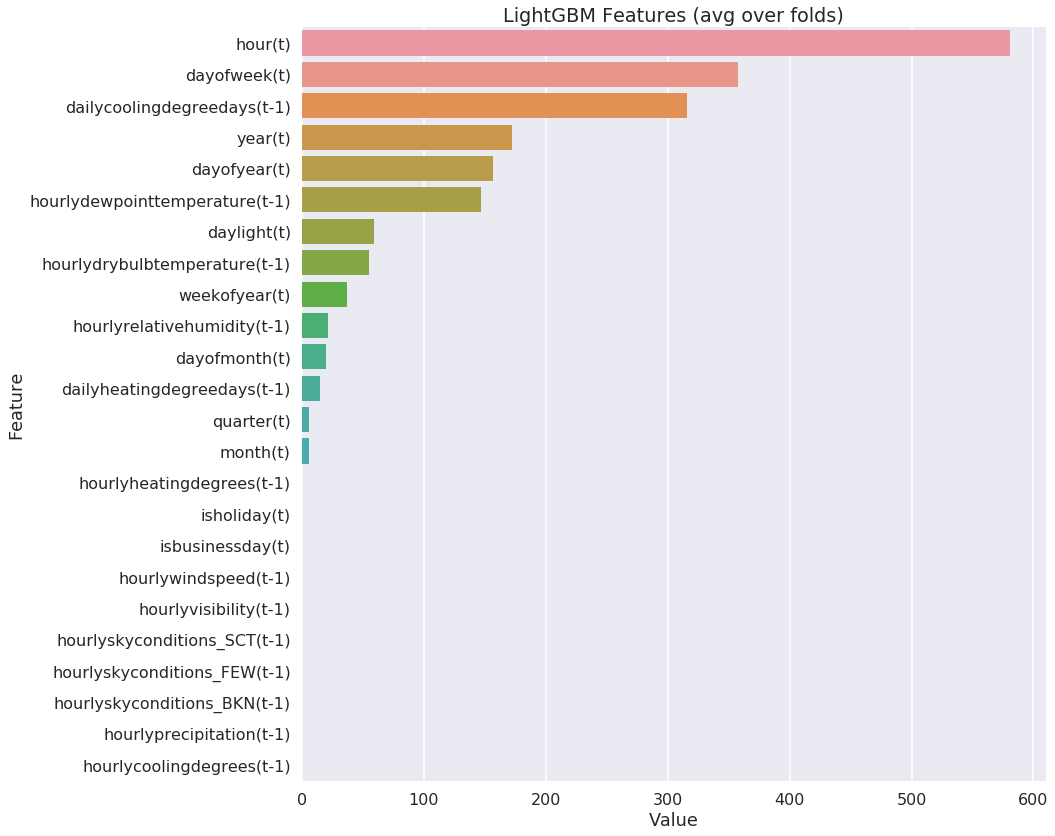

<Figure size 432x288 with 0 Axes>

In [97]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,X_train.columns)), columns=['Value','Feature'])
sns.set_context('poster')
sns.set_style("darkgrid")

plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [100]:
feature_imp.sort_values(by="Value", ascending=False)

,Value,Feature
23,581,hour(t)
22,358,dayofweek(t)
21,316,dailycoolingdegreedays(t-1)
20,172,year(t)
19,157,dayofyear(t)
18,147,hourlydewpointtemperature(t-1)
17,59,daylight(t)
16,55,hourlydrybulbtemperature(t-1)
15,37,weekofyear(t)
14,21,hourlyrelativehumidity(t-1)
